**Group X:**

- Lourenço Passeiro 20221838
- Miguel Marques 20221839
- Peter Lekszycki 20221840
- Tomás Gonçalves 20221894

## Imports:

In [ ]:
!pip install cleanvision
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.5 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Imports
import os
import glob

# Utils
from tqdm import tqdm
from multiprocessing import Pool
from joblib import Parallel, delayed
from concurrent.futures import ThreadPoolExecutor
from collections import Counter
import pickle

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns
import networkx as nx
import plotly.express as px

# Model selection
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Model design
import tensorflow as tf
import keras
from keras import layers, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Concatenate, Input, BatchNormalization, Activation
from sklearn.utils.class_weight import compute_class_weight
from keras.optimizers.schedules import ExponentialDecay
from keras.optimizers import Adam

# CNN
from keras.layers import Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D

# Transfer Learning
from keras.applications import VGG16, ResNet50

# Model Evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, precision_recall_curve, roc_curve, confusion_matrix, f1_score
from tensorflow_addons.metrics import F1Score

# Clustering
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# Manipulating images
import cv2
from google.colab.patches import cv2_imshow
from keras.preprocessing.image import ImageDataGenerator
from cleanvision import Imagelab
from skimage import img_as_ubyte

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
search_pattern = "drive/MyDrive/*/DeepLearning24_25/BreaKHis_v1/histology_slides/breast/image_data.csv"

# Use glob to find the file
file_paths = glob.glob(search_pattern)

if file_paths:
    file_path = file_paths[0]
    df = pd.read_csv(file_path)
    print("File loaded successfully!")

else:
    print("File not found. Please check the filename and path.")

File loaded successfully!


In [ ]:
# Define your directories
general_path = file_path[:36]
general_path

'drive/MyDrive/DL2/DeepLearning24_25/'

In [ ]:
df["path_to_image"] = df["path_to_image"].apply(lambda path: general_path + path)

In [ ]:
IMG_SIZE = 224

# Load and convert an image to a NumPy array
def load_image_as_array(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize the image to a fixed size
    image = cv2.cvtColor(image.astype("float32") / 255, cv2.COLOR_BGR2RGB)
    return np.array(image)


# Apply the function in parallel
with Pool() as pool:
    df["image"] = list(tqdm(pool.imap(load_image_as_array, df['path_to_image']), total=len(df)))

100%|██████████| 7909/7909 [01:27<00:00, 90.04it/s]


# Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7909 entries, 0 to 7908
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   path_to_image        7909 non-null   object
 1   Benign or Malignant  7906 non-null   object
 2   Cancer Type          7905 non-null   object
 3   Magnification        7905 non-null   object
 4   image                7909 non-null   object
dtypes: object(5)
memory usage: 309.1+ KB


In [ ]:
df.head()

path_to_image Benign or Malignant  \
0  drive/MyDrive/DL2/DeepLearning24_25/BreaKHis_v...              Benign   
1  drive/MyDrive/DL2/DeepLearning24_25/BreaKHis_v...              Benign   
2  drive/MyDrive/DL2/DeepLearning24_25/BreaKHis_v...              Benign   
3  drive/MyDrive/DL2/DeepLearning24_25/BreaKHis_v...              Benign   
4  drive/MyDrive/DL2/DeepLearning24_25/BreaKHis_v...              Benign   

  Cancer Type Magnification                                              image  
0    Adenosis          100X  [[[0.7529412, 0.7019608, 0.7882353], [0.686274...  
1    Adenosis          100X  [[[0.69803923, 0.65882355, 0.6901961], [0.7450...  
2    Adenosis          100X  [[[0.79607844, 0.83137256, 0.80784315], [0.776...  
3    Adenosis          100X  [[[0.80784315, 0.83137256, 0.80784315], [0.811...  
4    Adenosis          100X  [[[0.58431375, 0.57254905, 0.654902], [0.59607...

Benign or Malignant:

In [ ]:
df["Benign or Malignant"].value_counts(normalize=True)

Benign or Malignant
Malignant    0.686314
Benign       0.313686
Name: proportion, dtype: float64

In [ ]:
df["Benign or Malignant"].value_counts()

Benign or Malignant
Malignant    5426
Benign       2480
Name: count, dtype: int64

Our binary target is very unbalanced!

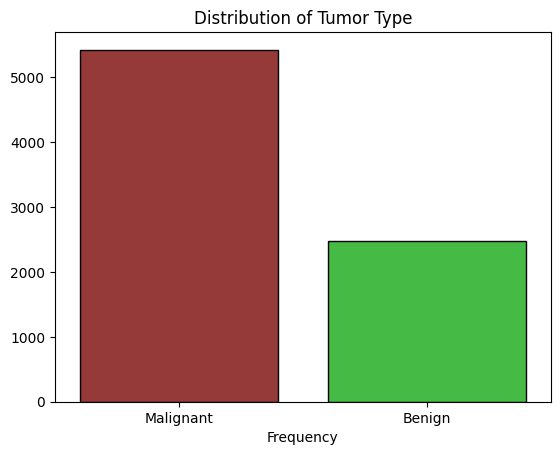

In [ ]:
sns.barplot(data=df["Benign or Malignant"].value_counts(), palette=["brown", "limegreen"], edgecolor="black", ci=None)
plt.title("Distribution of Tumor Type")
plt.xlabel("Frequency")
plt.ylabel("")
plt.show()

In [ ]:
benign_df = df.loc[df["Benign or Malignant"] == "Benign"]
malignant_df = df.loc[df["Benign or Malignant"] == "Malignant"]

Cancer Type:

In [ ]:
print("Benign types:")
print(benign_df["Cancer Type"].value_counts())
print()
print("Malignant types:")
print(malignant_df["Cancer Type"].value_counts())


Benign types:
Cancer Type
Fibroadenoma       1014
Tubular Adenoma     569
Phyllodes Tumor     453
Adenosis            444
Name: count, dtype: int64

Malignant types:
Cancer Type
Ductal Carcinoma       3450
Mucinous Carcinoma      789
Lobular Carcinoma       626
Papillary Carcinoma     560
Name: count, dtype: int64


The cancer types are different from benign to malignant!

In [ ]:
# also unbalanced - f1 score and class weights
df["Cancer Type"].value_counts(normalize=True)

Cancer Type
Ductal Carcinoma       0.436433
Fibroadenoma           0.128273
Mucinous Carcinoma     0.099810
Lobular Carcinoma      0.079190
Tubular Adenoma        0.071980
Papillary Carcinoma    0.070841
Phyllodes Tumor        0.057306
Adenosis               0.056167
Name: proportion, dtype: float64

Our multiclass target is also unbalanced!

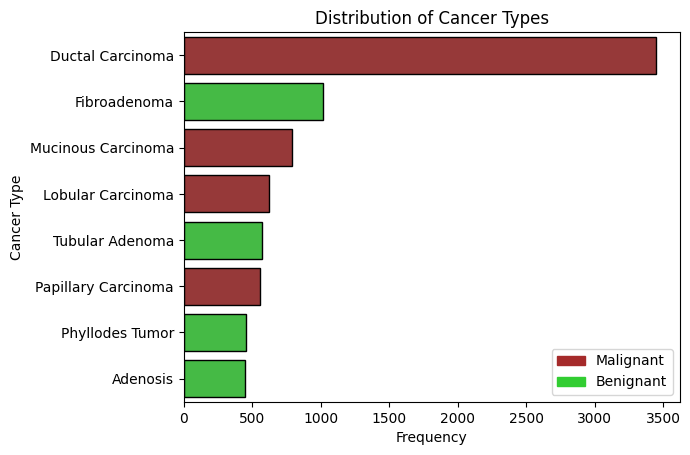

In [ ]:
cancer_counts = df["Cancer Type"].value_counts().reset_index()

color_mapping = {
    'Adenosis': 'limegreen',
    'Fibroadenoma': 'limegreen',
    'Phyllodes Tumor': 'limegreen',
    'Tubular Adenoma': 'limegreen',
    'Ductal Carcinoma': 'brown',
    'Lobular Carcinoma': 'brown',
    'Mucinous Carcinoma': 'brown',
    'Papillary Carcinoma': 'brown'
}

colors = [color_mapping[cancer_type] for cancer_type in cancer_counts['Cancer Type']]

sns.barplot(y='Cancer Type', x='count', data=cancer_counts, palette=colors, edgecolor="black")

plt.title("Distribution of Cancer Types")
plt.xlabel("Frequency")
plt.ylabel("Cancer Type")

red_patch = mpatches.Patch(color='brown', label='Malignant')
green_patch = mpatches.Patch(color='limegreen', label='Benignant')
plt.legend(handles=[red_patch, green_patch])
plt.show()

In [ ]:
import matplotlib.colors as mcolors
import plotly.express as px

tsne = TSNE(n_components=2, random_state=42, perplexity=40)

flattened_images = np.stack(df['image']).reshape(df['image'].shape[0], -1)
embedded_images = tsne.fit_transform(flattened_images)

unique_classes = df['Cancer Type'].value_counts().index
num_classes = len(unique_classes)
class_encoded = LabelEncoder().fit_transform(df["Cancer Type"])

# Convert Matplotlib's 'tab10' colormap to Plotly-compatible hex colors
cmap = plt.get_cmap('tab10')
tab10_colors = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

data = pd.DataFrame({
    'x': embedded_images[:, 0],
    'y': embedded_images[:, 1],
    'class': [unique_classes[i-1] for i in class_encoded]})

fig = px.scatter(
    data,
    x='x',
    y='y',
    color='class',
    title="2-Dimensional t-SNE of Cancer Type",
    color_discrete_sequence=tab10_colors,
    template="plotly")

fig.update_layout(
    legend_title_text='Classes',
    legend=dict(
        title_font=dict(size=12),
        font=dict(size=10),
        x=0.01,
        y=0.99),
      width=950,
      height=700)

fig.show()

The t-SNE scatter plot helps us understand the similarity between classes. Ductal Carcinoma, the majority class, is all over the place. However, we filtered it out, we can see tendencies between classes more clearly.

In [ ]:
adenosis = df.loc[df["Cancer Type"] == "Adenosis"]
fibroadenoma = df.loc[df["Cancer Type"] == "Fibroadenoma"]
phyllodes_tumor = df.loc[df["Cancer Type"] == "Phyllodes Tumor"]
tubular_adenoma =  df.loc[df["Cancer Type"] == "Tubular Adenoma"]
ductal_carcinoma = df.loc[df["Cancer Type"] == "Ductal Carcinoma"]
lobular_carcinoma = df.loc[df["Cancer Type"] == "Lobular Carcinoma"]
mucinous_carcinoma = df.loc[df["Cancer Type"] == "Mucinous Carcinoma"]
papillary_carcinoma = df.loc[df["Cancer Type"] == "Papillary Carcinoma"]

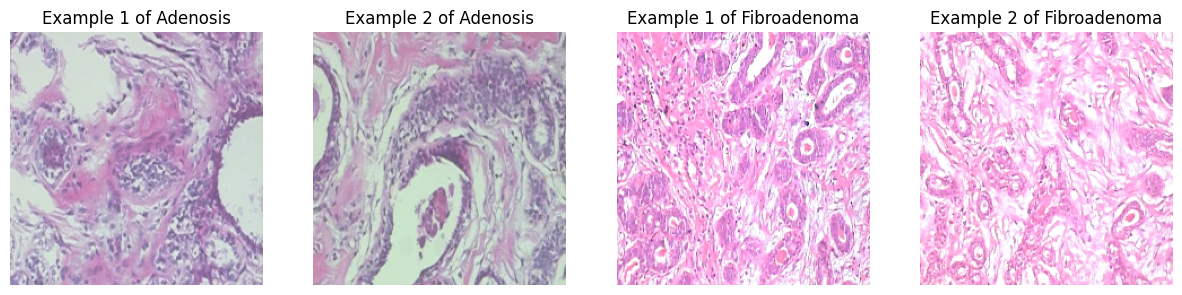

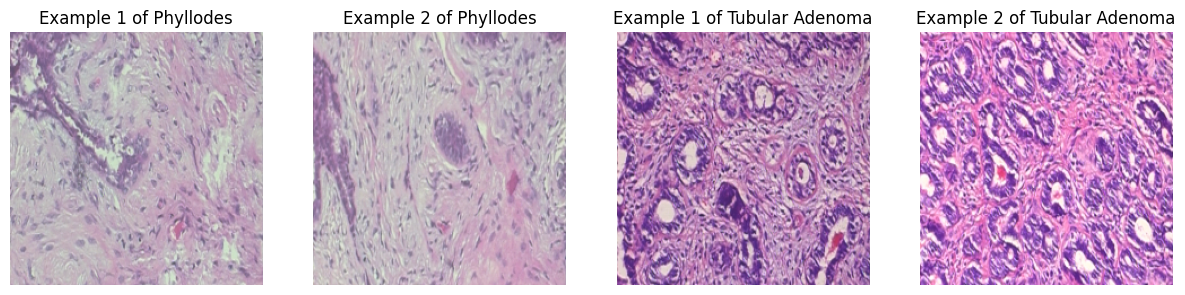

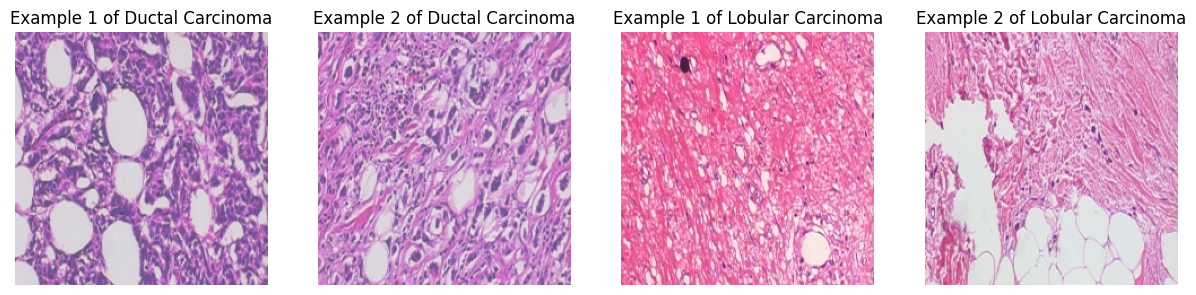

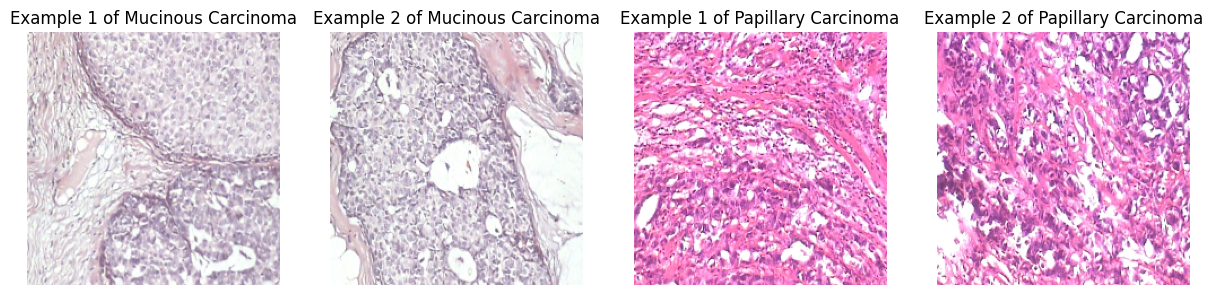

In [ ]:
def display_images(label1, label2, list1, list2):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    for i, ax in enumerate(zip(axes[:2], list1[:2])):
        ax[0].imshow(ax[1])
        ax[0].set_title(f"Example {i+1} of {label1}")
        ax[0].axis('off')

    for i, ax in enumerate(zip(axes[2:], list2[:2])):
        ax[0].imshow(ax[1])
        ax[0].set_title(f"Example {i+1} of {label2}")
        ax[0].axis('off')

    plt.show()

# Display images from cancer type
display_images("Adenosis", "Fibroadenoma", adenosis.image, fibroadenoma.image)
display_images("Phyllodes","Tubular Adenoma", phyllodes_tumor.image, tubular_adenoma.image)
display_images("Ductal Carcinoma","Lobular Carcinoma", ductal_carcinoma.image, lobular_carcinoma.image)
display_images("Mucinous Carcinoma","Papillary Carcinoma", mucinous_carcinoma.image, papillary_carcinoma.image)

Magnification:

In [ ]:
# Balanced classes
df.Magnification.value_counts(normalize=True)

Magnification
100X    0.263125
200X    0.254522
40X     0.252245
400X    0.230108
Name: proportion, dtype: float64

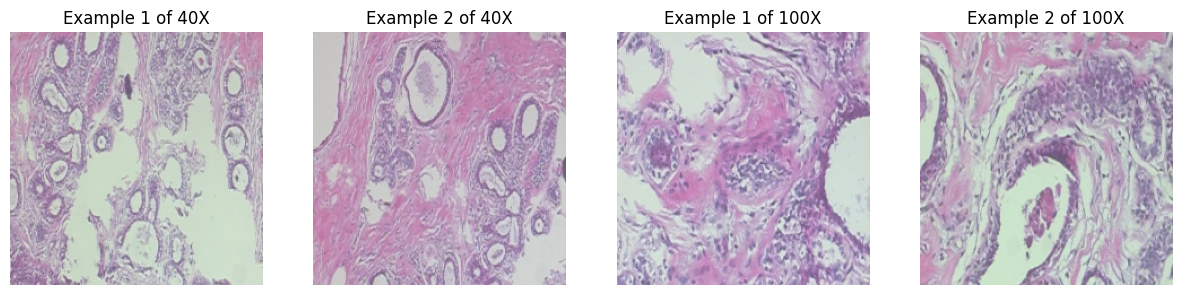

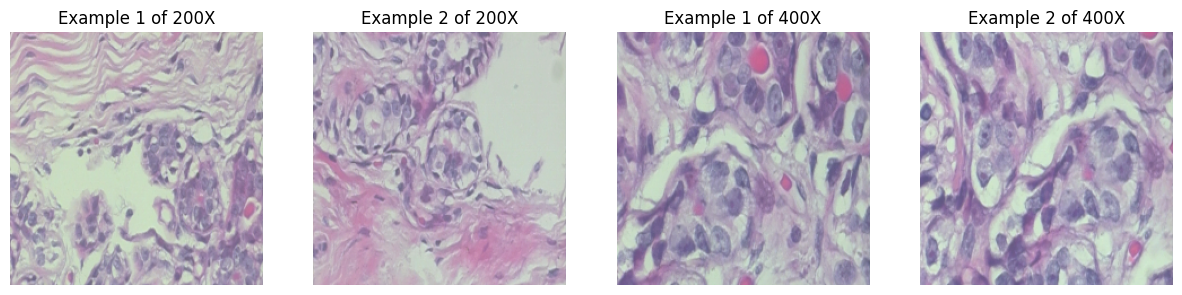

In [ ]:
mag40 = df.query('`Magnification` == "40X" and (`Benign or Malignant` == "Benign" and `Cancer Type` == "Adenosis")')
mag100 = df.query('`Magnification` == "100X" and (`Benign or Malignant` == "Benign" and `Cancer Type` == "Adenosis")')
mag200 = df.query('`Magnification` == "200X" and (`Benign or Malignant` == "Benign" and `Cancer Type` == "Adenosis")')
mag400 = df.query('`Magnification` == "400X" and (`Benign or Malignant` == "Benign" and `Cancer Type` == "Adenosis")')

display_images("40X", "100X", mag40.image, mag100.image)
display_images("200X","400X", mag200.image, mag400.image)

We can also see that each level of magnification produces very different images.

In [ ]:
df.groupby(["Benign or Malignant", "Magnification"]).count()

path_to_image  Cancer Type  image
Benign or Malignant Magnification                                   
Benign              100X                     644          644    644
                    200X                     623          623    623
                    400X                     588          588    588
                    40X                      625          625    625
Malignant           100X                    1436         1436   1436
                    200X                    1389         1389   1389
                    400X                    1231         1231   1231
                    40X                     1369         1369   1369

In [ ]:
df.groupby(["Benign or Malignant", "Cancer Type", "Magnification"])['image'].count()

Benign or Malignant  Cancer Type          Magnification
Benign               Adenosis             100X             113
                                          200X             111
                                          400X             106
                                          40X              114
                     Fibroadenoma         100X             260
                                          200X             264
                                          400X             237
                                          40X              253
                     Phyllodes Tumor      100X             121
                                          200X             108
                                          400X             115
                                          40X              109
                     Tubular Adenoma      100X             150
                                          200X             140
                                          400X             130
                                          40X              149
Malignant            Ductal Carcinoma     100X             903
                                          200X             896
                                          400X             788
                                          40X              863
                     Lobular Carcinoma    100X             170
                                          200X             163
                                          400X             137
                                          40X              156
                     Mucinous Carcinoma   100X             221
                                          200X             195
                                          400X             168
                                          40X              205
                     Papillary Carcinoma  100X             142
                                          200X             135
                                          400X             138
                                          40X              145
Name: image, dtype: int64

# Data Preprocessing

## Duplicates

There are 2 hypothesis that our original dataframe contains duplicate images:

*   2 or more rows of the dataframe have the same path to image, so they will load the same image.
*   The lines can have different paths but carry the same image.

In [ ]:
len(df) - df['path_to_image'].nunique()

0

Our dataset has exactly 7909 rows. The first hypothesis is ruled out. To verify the second hypothesis, we will use the ImageLab library, which checks whether each image is exclusively unique, that is, there are no images with the same array of pixels.

Checking for exact_duplicates images ...


  0%|          | 0/7909 [00:00<?, ?it/s]

Issue checks completed. 250 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | exact_duplicates |          250 | 

----------------- exact_duplicates images ------------------

Number of examples with this issue: 250
Examples representing most severe instances of this issue:

Set: 0


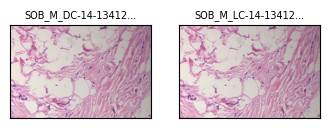

Set: 1


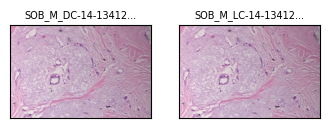

Set: 2


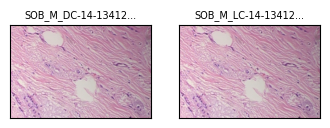

Set: 3


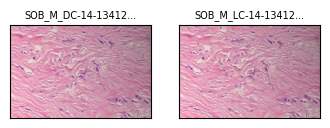

In [ ]:
# Searching for duplicated images
imagelab = Imagelab(filepaths=list(df["path_to_image"]))
imagelab.find_issues({"exact_duplicates":{}})
imagelab.report(verbosity=4)

In [ ]:
# Filtering all the duplicated images paths
duplicated_paths = imagelab.issues[["is_exact_duplicates_issue"]].any(axis=1).reset_index().rename(columns={"index": "path_to_image", 0: "duplicated"})
duplicated_paths = duplicated_paths.loc[duplicated_paths["duplicated"] == True]
duplicated_paths.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 5267 to 7869
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   path_to_image  250 non-null    object
 1   duplicated     250 non-null    bool  
dtypes: bool(1), object(1)
memory usage: 4.2+ KB


250 duplicated images were found. We only need one image from each pair of duplicates. But are there 125 or 250 pairs?

In [ ]:
# Joining the duplicates with the main data to have more information about them
duplicated_images = df.merge(duplicated_paths, on='path_to_image', how='right')
# Creating a feature to store the string version of each image, in order to compare them
duplicated_images['image_str'] = duplicated_images['image'].apply(lambda x: str(x.flatten()))
# Getting number of duplicated pairs
duplicated_images.image_str.nunique()

125

There are 125 unique duplicated images. That means that there are groups of odd duplicates. Let's group them together.

In [ ]:
duplicated_images['index_group'] = duplicated_images.groupby('image_str').ngroup() +1
duplicated_images = duplicated_images.sort_values(by='index_group', ascending=True)

In [ ]:
duplicated_images.head(4)

path_to_image Benign or Malignant  \
208  drive/MyDrive/DL2/DeepLearning24_25/BreaKHis_v...           Malignant   
64   drive/MyDrive/DL2/DeepLearning24_25/BreaKHis_v...           Malignant   
142  drive/MyDrive/DL2/DeepLearning24_25/BreaKHis_v...           Malignant   
22   drive/MyDrive/DL2/DeepLearning24_25/BreaKHis_v...           Malignant   

           Cancer Type Magnification  \
208  Lobular Carcinoma           40X   
64    Ductal Carcinoma           40X   
142  Lobular Carcinoma          100X   
22    Ductal Carcinoma          100X   

                                                 image  duplicated  \
208  [[[0.5686275, 0.43137255, 0.5176471], [0.6, 0....        True   
64   [[[0.5686275, 0.43137255, 0.5176471], [0.6, 0....        True   
142  [[[0.60784316, 0.43137255, 0.56078434], [0.584...        True   
22   [[[0.60784316, 0.43137255, 0.56078434], [0.584...        True   

                                             image_str  index_group  
208  [0.5686275  0.43137255 0.5176471  ... 0.678431...            1  
64   [0.5686275  0.43137255 0.5176471  ... 0.678431...            1  
142  [0.60784316 0.43137255 0.56078434 ... 0.698039...            2  
22   [0.60784316 0.43137255 0.56078434 ... 0.698039...            2

Now, the goal is to check if there is unanimous pairs of duplicates, that is, pairs on which that have the same values for all variables. One of the elements of these pairs will stay on our data.

In [ ]:
lines_keep = []

# Iterate over the dataset in steps of 2 (by pairs)
for i in range(0, len(duplicated_images) - 1, 2):
    # Extract relevant rows
    elem1 = duplicated_images.iloc[i]
    elem2 = duplicated_images.iloc[i + 1]

    # Check if they are the same
    if (elem1[["Benign or Malignant", "Cancer Type"]].equals(
        elem2[["Benign or Malignant", "Cancer Type"]])):

        # Append indices of both rows if they match
        lines_keep.extend([i, i + 1])

lines_keep

[142, 143, 164, 165]

In this case, we will keep the first line of each pair. All other lines of the 250 will be removed.

In [ ]:
index_to_keep = [lines_keep[i] for i in range(0, len(lines_keep), 2)]

duplicated_images = duplicated_images.drop(index_to_keep, axis=0)

In [ ]:
# Removing the rest from our data
df = df[~df["path_to_image"].isin(duplicated_images["path_to_image"])]

In [ ]:
len(df)

7661

## Missing values

4 records have missing values

In [ ]:
df[df.isna().any(axis=1)]

path_to_image Benign or Malignant  \
2871  drive/MyDrive/DL2/DeepLearning24_25/BreaKHis_v...                 NaN   
3093  drive/MyDrive/DL2/DeepLearning24_25/BreaKHis_v...           Malignant   
3228  drive/MyDrive/DL2/DeepLearning24_25/BreaKHis_v...                 NaN   
4536  drive/MyDrive/DL2/DeepLearning24_25/BreaKHis_v...                 NaN   

     Cancer Type Magnification  \
2871         NaN           NaN   
3093         NaN           NaN   
3228         NaN           NaN   
4536         NaN           NaN   

                                                  image  
2871  [[[0.60784316, 0.36862746, 0.627451], [0.61960...  
3093  [[[0.8862745, 0.7058824, 0.9019608], [0.854901...  
3228  [[[0.70980394, 0.75686276, 0.6901961], [0.7176...  
4536  [[[0.7411765, 0.7058824, 0.7411765], [0.756862...

We can easily discover the missing data by checking the path to image!

In [ ]:
missing_rows = df[df.isna().any(axis=1)]

for idx, path in zip(missing_rows.index, missing_rows.path_to_image):
    parts = path.split('/')

    df.loc[idx, 'Benign or Malignant'] = parts[7]
    df.loc[idx, 'Cancer Type'] = parts[9]
    df.loc[idx, 'Magnification'] = parts[11]

In [ ]:
df.loc[[2871, 3093, 3228, 4536]]

path_to_image Benign or Malignant  \
2871  drive/MyDrive/DL2/DeepLearning24_25/BreaKHis_v...           malignant   
3093  drive/MyDrive/DL2/DeepLearning24_25/BreaKHis_v...           malignant   
3228  drive/MyDrive/DL2/DeepLearning24_25/BreaKHis_v...           malignant   
4536  drive/MyDrive/DL2/DeepLearning24_25/BreaKHis_v...           malignant   

             Cancer Type Magnification  \
2871  mucinous_carcinoma          100X   
3093  mucinous_carcinoma          200X   
3228  mucinous_carcinoma          400X   
4536    ductal_carcinoma           40X   

                                                  image  
2871  [[[0.60784316, 0.36862746, 0.627451], [0.61960...  
3093  [[[0.8862745, 0.7058824, 0.9019608], [0.854901...  
3228  [[[0.70980394, 0.75686276, 0.6901961], [0.7176...  
4536  [[[0.7411765, 0.7058824, 0.7411765], [0.756862...

In [ ]:
df[df.isna().any(axis=1)]

Empty DataFrame
Columns: [path_to_image, Benign or Malignant, Cancer Type, Magnification, image]
Index: []

## Data Transformations

Benign or Malignant:

In [ ]:
# Encoding the tumor type
df["malignant"] = df["Benign or Malignant"].apply(lambda x: 1 if x.lower() == "malignant" else 0)
df.drop(["Benign or Malignant", "path_to_image"], axis=1, inplace=True)

Cancer type:

In [ ]:
# Encoding the cancer type, while removing spaces and keeping everything in lower case - easier to wrangle
df["cancer_type"] = df["Cancer Type"].apply(lambda x: str(x).lower().replace(" ", "_"))
df.drop("Cancer Type", axis=1, inplace=True)

Diving the samples by their magnification levels:

In [ ]:
np.unique( df.Magnification )

array(['100X', '200X', '400X', '40X'], dtype=object)

In [ ]:
images_40x = df.loc[df["Magnification"] == "40X"]
images_100x = df.loc[df["Magnification"] == "100X"]
images_200x = df.loc[df["Magnification"] == "200X"]
images_400x = df.loc[df["Magnification"] == "400X"]

Hashing the images, to facilitate future comparisons:

In [ ]:
# Hash the images to facilitate the comparison
def hash_image(img):
    return hash(img.tobytes())

df['hash'] = df['image'].map(hash_image)

## Image Transformations

We perfomed image resizing and normalizing at the importation of the images, in order to improve efficiency. Nonetheless, we noticed that almost every image had a shape of 460x700, with the exception of a few images with a height of 456. This was dealt it when we resized every image to 256x256, a image size small enough to speed up the computations, and big enough to our models be able to succeed.

### Color Space

Changing the color space can emphasize specific features, making patterns easier for models to detect.

Gray Scaling:

Most of edge and texture detection transformations require gray-scaled images as input:

In [ ]:
def gray_transformer(images):
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])

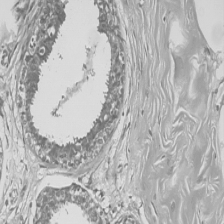

In [ ]:
gray_images = gray_transformer(df.image)
cv2_imshow(img_as_ubyte(gray_images[10]))

HSV:

In [ ]:
def hsv_transformer(images):
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2HSV) for img in images])

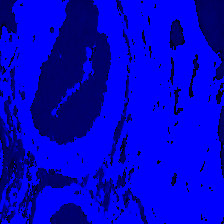

In [ ]:
hsv_images = hsv_transformer(df.image)
cv2_imshow(hsv_images[10])

LAB:

In [ ]:
def lab_transformer(images):
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2Lab) for img in images])

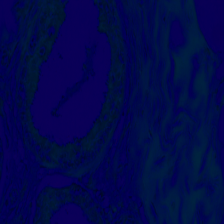

In [ ]:
lab_images = lab_transformer(df.image)
cv2_imshow(lab_images[10])

### Image Denoising

Image denoising removes noise to enhance image quality, preserving important features while smoothing unwanted parts.

In [ ]:
def denoise_images_parallel(images, h=10, h_color=10, template_window_size=7, search_window_size=21, color_space='rgb'):

    def denoise_single_image(img):
        if color_space == 'rgb':
            return cv2.fastNlMeansDenoisingColored(
                (img * 255).astype(np.uint8), None, h, h_color, template_window_size, search_window_size) / 255

        # For HSV and LAB it is enough to apply it to their V and L channels, respectively,
        # as it is on that channels that the majority of noise resides
        elif color_space == 'hsv':
            h, s, v = cv2.split(img)

            v_denoised = cv2.fastNlMeansDenoisingColored( (v * 255).astype(np.uint8), None, h, h_color, template_window_size, search_window_size) / 255

            return cv2.merge([h, s, v_denoised])

        elif color_space == 'lab'
            l, a, b = cv2.split(img)

            l_denoised = cv2.fastNlMeansDenoisingColored( (l * 255).astype(np.uint8), None, h, h_color, template_window_size, search_window_size) / 255

            return cv2.merge([l_denoised, a, b])

    # Process images in parallel with progress tracking
    with ThreadPoolExecutor() as executor:
        denoised_images = list(
            tqdm(
                executor.map(denoise_single_image, images),
                total=len(images),
                desc="Denoising Images"))

    return np.array(denoised_images)

In [ ]:
images_denoised = denoise_images_parallel(df.image)

Denoising Images: 100%|██████████| 7661/7661 [00:39<00:00, 196.32it/s]


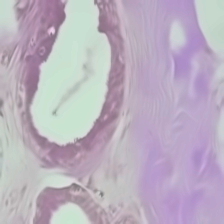

In [ ]:
cv2_imshow(img_as_ubyte(images_denoised[10]))

### Gradient Filters

Gradient filters detect edges by calculating intensity changes in an image, highlighting transitions or boundaries.

Sobel Derivative

In [ ]:
def sobel_derivatives(images, axis='both'):
    gray_images = gray_transformer(images)
    sobelx = np.array([cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3) for gray in gray_images])
    sobely = np.array([cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3) for gray in gray_images])

    if axis == 'x':
        return sobelx

    elif axis == 'y':
        return sobely

    else:
        return np.sqrt(sobelx**2 + sobely**2)

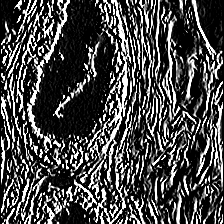

In [ ]:
sobel = sobel_derivatives(df.image, axis='x')
cv2_imshow(sobel[10]*255)

Laplasian Derivative

In [ ]:
def laplacian_transformer(images):
    return np.array([cv2.Laplacian((img * 255).astype(np.uint8), cv2.CV_64F) / 255 for img in gray_transformer(images)])

In [ ]:
laplacian_images = laplacian_transformer(df.image)

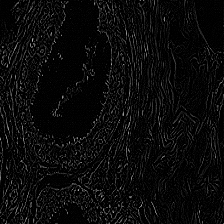

In [ ]:
cv2_imshow(img_as_ubyte(laplacian_images[10]))

### Edge Detection

It help identifying boundaries in an image by detecting significant intensity changes, highlighting object shapes and structures.

Canny Edge Detector

In [ ]:
def canny_transformer(images, color_space='rgb'):
    edges = []
    if color_space == 'rgb':
        return np.array([cv2.Canny(cv2.convertScaleAbs((img * 255).astype(np.uint8)), 50, 150) / 255  for img in gray_transformer(images)])

    # Applying only in the brightness channels of HSV and LAB is enough
    if color_space == 'hsv':
        for img in images:
            h, s, v = cv2.split(img)
            edges.append( cv2.Canny((v * 255).astype(np.uint8), 50, 150) / 255 ) # Canny required 0-255 8-bit images

    elif color_space == 'lab':
        for img in images:
            l, a, b = cv2.split(img)
            edges.append( ( cv2.Canny( ((l / 100)*255 ).astype(np.uint8), 50, 150) / 255 )*100 ) # Canny required 0-255 8-bit images

    return np.array([cv2.merge([edge, edge, edge]) for edge in edges])

In [ ]:
canny_images = canny_transformer(df.image)

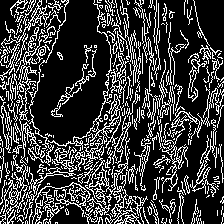

In [ ]:
cv2_imshow(img_as_ubyte(canny_images[10]))

### Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
datagen_aggressive = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Helper Functions & Pipelines

Oversampling functions:

In [ ]:
def augment_binary_class(train_data, augmented_class, datagen=datagen):
    """
    Augments a binary class to reach the target size.

    Args:
        train_data (DataFrame): DataFrame with 'image' and 'label' columns.
        target_size (int): Desired total number of images after augmentation.
        datagen (ImageDataGenerator): Keras ImageDataGenerator for augmentation.

    Returns:
        np.array: Augmented images.
    """
    # For reproducibility
    rng = np.random.default_rng(24)

    # Minority class images
    images = train_data.loc[train_data.label == augmented_class].image
    # Number of augmented images created to match the number of samples of the majority class
    target_size = train_data.label.value_counts().max() - train_data.label.value_counts().min()
    # Randomly chosen images that will used to augmentation
    sample_images = np.random.choice(images, size=target_size, replace=True)

    augmented_images = []
    for img in tqdm(sample_images, desc="Augmenting Binary Class"):
        img = img.reshape((1,) + img.shape)  # Add batch dimension

        # Generate a single augmented image
        for batch in datagen.flow(img, batch_size=1):
            augmented_images.append(batch[0])
            break

    return np.asarray(augmented_images)

In [ ]:
def augment_multiclass(train_data, target_size, num_classes, datagen=datagen):
    """
    Augments multiple classes to reach the target size per class.

    Args:
        train_data (DataFrame): DataFrame with 'image' and 'label' columns.
        target_size (int): Desired total number of images per class after augmentation.
        num_classes (int): Number of classes.
        datagen (ImageDataGenerator): Keras ImageDataGenerator for augmentation.

    Returns:
        dict: Dictionary of augmented images for each class.
    """
    # For reproducibility
    rng = np.random.default_rng(24)

    augmented_classes = {}
    # For each possible label, separate their images and the number of images needed to match the target size
    for label in range(num_classes):
        images_class = train_data.loc[train_data['label'] == label, 'image']
        number_to_augment = target_size - len(images_class)
        if number_to_augment <= 0:
            continue  # No need to augment if already at or above target size

        augmented_images = []
        sample_images = np.random.choice(images_class, size=number_to_augment, replace=True)
        sample_images = [np.array(img) for img in sample_images]

        # Augment images in batches
        for img_batch in tqdm(sample_images, desc=f"Augmenting Class {label}", leave=False):
            # Were getting errors using the images normalized, so we converted it to their normal range,
            # and will re-normalize them in the end
            img_batch = img_batch * 255
            img_batch = np.expand_dims(img_batch, axis=0)  # Add a batch dimension

            for batch in datagen.flow(img_batch, batch_size=32):
                for img in batch:
                    augmented_images.append(img / 255)
                if len(augmented_images) >= number_to_augment:
                    break  # Stop when we've generated enough images for this class

            if len(augmented_images) >= number_to_augment:
                break  # Exit outer loop once we have the required number of augmented images

        augmented_classes[label] = np.asarray(augmented_images)

    return augmented_classes

In [ ]:
def apply_oversampling(X_train, y_train, problem, target_size=None):
    """
    Applies oversampling to balance class distribution.

    Args:
        X_train (array): Training data (images).
        y_train (array): Corresponding labels.
        problem (str): 'binary' or 'multiclass' problem type.
        target_size (int): Target size per class for multiclass.

    Returns:
        tuple: Augmented training data (X_train_augmented, y_train_augmented).
    """

    train_set = pd.DataFrame({'image': list(X_train), 'label': y_train})

    if problem == 'binary':
        class_to_augment = train_set.label.value_counts().idxmin()    # Class that will be augmented
        augmented_images = augment_binary_class(train_data=train_set,augmented_class=class_to_augment)
        df_augmented = pd.DataFrame({'image': list(augmented_images), 'label': class_to_augment})
        train_set = pd.concat([ train_set, df_augmented ])  # Join the augmented to the original images

    else:
        augmented_images = augment_multiclass(train_data=train_set, target_size=target_size, num_classes=8)
        # Join the augmented images of every class to the original ones
        for label, images in augmented_images.items():
            df_augmented = pd.DataFrame({'image': list(images), 'label': label})
            train_set = pd.concat([ train_set, df_augmented ])

    # Transform the train set Df into separate arrays again
    X_train_augmented = np.stack(train_set.image)
    y_train_augmented = train_set.label
    X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented, random_state=24)

    return X_train_augmented, y_train_augmented

Undersampling functions:

In [ ]:
def get_embedding(image):
    """
    Generates an embedding for an image using a pre-trained ResNet50 model.

    Args:
        image (array): Input image array.

    Returns:
        array: Flattened embedding vector for the input image.
    """

    model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
    image = np.expand_dims(image, axis=0)
    embedding = model.predict(image, verbose=0)
    return embedding.flatten()

In [ ]:
def similarity_undersampler(images, percent_to_drop):
    """
    Performs undersampling by removing similar images based on their embeddings.

    Args:
        images (list): List of input images to be undersampled.
        percent_to_drop (float): Percentage of images to drop based on similarity (between 0 and 1).

    Returns:
        list: Indices of the images to keep after undersampling.
    """

    # Generating the embeddings in parallel to speed up
    with Parallel(n_jobs=-1) as parallel:
        image_embeddings = np.array(parallel(delayed(get_embedding)(img) for img in tqdm(images, leave=False)))

    # Clustering the embeddings in Number of Images / (1 / percentage of drop) clusters
    # Example: If we want to drop half the class, we will have 1 / 0.5 = 2 ; Number of Images / 2 clusters, distributing the images there
    num_clusters = len(image_embeddings) // round(1 / percent_to_drop)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(image_embeddings)

    # Evaluating the redundancy of each image
    redundancy_scores = []
    # Iterating over every assigned formed cluster
    for cluster_id in tqdm(np.unique(cluster_labels)):
        # Getting the embedding of every image on the cluster
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        cluster_embeddings = image_embeddings[cluster_indices]

        # Computing the similarities between each cluster member
        similarity_matrix = cosine_similarity(cluster_embeddings)

        # The redundancy score is the sum of the similarity of each image to the ones on its cluster
        scores = similarity_matrix.sum(axis=1)
        redundancy_scores.extend(zip(cluster_indices, scores))

    redundancy_scores.sort(key=lambda x: x[1], reverse=True)

    return list(dict(redundancy_scores[:round(percent_to_drop*len(image_embeddings))]).keys())

In [ ]:
def apply_undersampling(X_train, y_train, percent_to_drop):
    """
    Performs undersampling by reducing the number of majority class samples.

    Args:
        X_train (array): Training images.
        y_train (array): Corresponding labels.
        percent_to_drop (float): Percentage of majority class samples to drop (0 to 1).

    Returns:
        tuple: Undersampled training data (X_train_reduced, y_train_reduced).
    """
    # If we want to drop 0% of the images, we just return the inputs
    if percent_to_drop <= 0:
        return X_train, y_train

    train_set = pd.DataFrame({'image': list(X_train), 'label': y_train})

    majority_label = pd.Series(y_train).value_counts().index[0]
    majority_images = train_set.loc[train_set.label == majority_label]

    # Getting the indexes of the most redundant images
    idxs_to_drop = majority_images.index[similarity_undersampler(majority_images.image, percent_to_drop)]
    # Dropping them
    train_set.drop(idxs_to_drop, inplace=True)

    # Transform the train set Df into separate arrays again
    X_train_reduced = np.stack(train_set.image)
    y_train_reduced = train_set.label
    X_train_reduced, y_train_reduced = shuffle(X_train_reduced, y_train_reduced, random_state=24)

    return X_train_reduced, y_train_reduced

Evaluation functions:

In [ ]:
def accuracy_loss_plot(history):
  """
  Plots training and validation accuracy and loss over epochs.

  Args:
      history (History): Keras History object containing training history.

  Returns:
      None: Displays the plot of accuracy and loss.
  """

  epochs = range(1, len(history.history['accuracy']) + 1)
  acc_train = history.history['accuracy']
  acc_val = history.history['val_accuracy']
  loss_train = history.history['loss']
  loss_val = history.history['val_loss']

  fig, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True)

  ax[0].plot(epochs, acc_train, 'g', label='Training accuracy')
  ax[0].plot(epochs, acc_val, 'b', label='Validation accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss_train, 'g', label='Training loss')
  ax[1].plot(epochs, loss_val, 'b', label='Validation loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  plt.show()

In [ ]:
def f1_loss_plot(history):
  """
  Plots training and validation accuracy and loss over epochs.

  Args:
      history (History): Keras History object containing training history.

  Returns:
      None: Displays the plot of accuracy and loss.
  """

  epochs = range(1, len(history.history['f1_score']) + 1)
  acc_train = history.history['f1_score']
  acc_val = history.history['val_f1_score']
  loss_train = history.history['loss']
  loss_val = history.history['val_loss']

  fig, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True)

  ax[0].plot(epochs, acc_train, 'g', label='Training F1-Score')
  ax[0].plot(epochs, acc_val, 'b', label='Validation F1-Score')
  ax[0].set_title('Training and Validation F1-Score')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('F1-Score')
  ax[0].legend()

  ax[1].plot(epochs, loss_train, 'g', label='Training loss')
  ax[1].plot(epochs, loss_val, 'b', label='Validation loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  plt.show()

In [ ]:
def evaluate_model(model, labels, labels_prob):
    """
    Evaluates the model using ROC-AUC, Precision-Recall curves, and Confusion Matrix.

    Args:
        model (object): The trained model to evaluate.
        labels (array): True labels.
        labels_prob (array): Predicted probabilities for the positive class.

    Returns:
        None: Displays the evaluation plots and prints classification report.
    """

    fig, axes = plt.subplots(ncols=3, figsize=(14, 4))

    # Titles for each subplot
    titles = ["ROC-AUC Curve", "Precision-Recall Curve", "Confusion Matrix"]

    # Plot ROC curve, Precision-Recall Curve, and Confusion Matrix
    curves = [metrics.RocCurveDisplay, metrics.PrecisionRecallDisplay]

    for ax, curve, title in zip(axes[:2], curves, titles[:2]):
        curve.from_predictions(labels, labels_prob, ax=ax, name=model.__class__.__name__)
        ax.set_title(title, size=14, pad=10)

    # Plot Confusion Matrix
    label_predictions = (labels_prob >= 0.5).astype(int)
    metrics.ConfusionMatrixDisplay.from_predictions(labels, label_predictions, ax=axes[2], colorbar=False, normalize='true')
    axes[2].set_title(titles[2], size=14, pad=10)

    print(classification_report(labels, label_predictions))

    plt.tight_layout()
    plt.show()

# Modelling

## General Data Preparation

In [ ]:
X = np.stack(df.image)

y_binary = df.malignant

enc = LabelEncoder()
y_multi = enc.fit_transform(df.cancer_type)

double_stratify is essential for splitting the data, ensuring that both classes and subclasses are represented evenly on every set.

In [ ]:
# Train-test split
double_stratify = np.array([f"{classe}_{subclass}" for classe, subclass in zip(y_binary, y_multi)])

X_train, X_test_old, y_binary_train, y_binary_test_old, y_multi_train, y_multi_test_old = train_test_split(X, y_binary, y_multi, test_size=0.3,
                                                                                               random_state=42, stratify=double_stratify, shuffle=True)

In [ ]:
# Val-test split
double_stratify_test = np.array([f"{classe}_{subclass}" for classe, subclass in zip(y_binary_test_old, y_multi_test_old)])

X_val, X_test, y_binary_val, y_binary_test, y_multi_val, y_multi_test = train_test_split(X_test_old, y_binary_test_old, y_multi_test_old, test_size=0.51,
                                                                                               random_state=42, stratify=double_stratify_test, shuffle=True)

## Stage 1: Binary Classification

### Data Preparation

Given the big class imbalance, we will perform oversampling:

In [ ]:
X_train_binary, y_binary_train = apply_oversampling(X_train, y_binary_train, problem='binary')

Augmenting Binary Class: 100%|██████████| 1890/1890 [00:20<00:00, 93.67it/s]


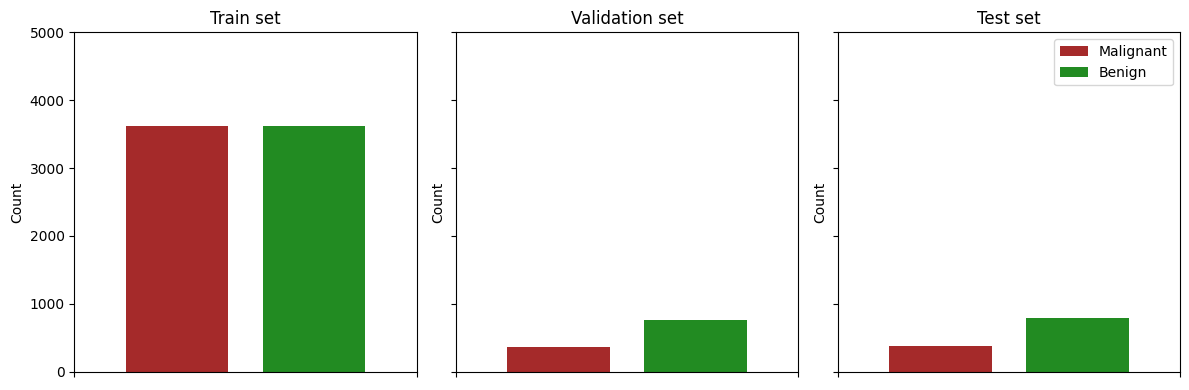

In [ ]:
train_counts = Counter(y_binary_train)
val_counts = Counter(y_binary_val)
test_counts = Counter(y_binary_test)

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

width = 0.3

for (i, counts), split in zip( enumerate([train_counts, val_counts, test_counts]), ['Train', 'Validation', 'Test']):
    classes = list(counts.keys())
    counts = list(counts.values())

    ax[i].bar(0.3, counts[0], width=width, color='brown', label='Malignant')
    ax[i].bar(0.7, counts[1], width=width, color='forestgreen', label='Benign')
    ax[i].set_xticks([0, 1])
    ax[i].set_xticklabels(['', ''])
    ax[i].set_title(f'{split} set')
    ax[i].set_ylabel('Count')
    ax[i].set_ylim(0, 5000)

plt.legend()
plt.tight_layout()
plt.show()

Here we applied some pre-trained models

### Model Design

In [ ]:
binary_base_model = VGG16(weights='imagenet',
                          include_top=False,
                          input_shape=(224, 224, 3)
                          )

binary_base_model.trainable = False

# Unfreezing the last 8 layers (2 convolutional blocks)
for layer in binary_base_model.layers[-8:]:
   layer.trainable = True

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
binary_model = Sequential()
binary_model.add(binary_base_model)
binary_model.add(Flatten())

binary_model.add(Dropout(0.5))

binary_model.add(Dense(512, activation="relu"))
binary_model.add(Dropout(0.5))

binary_model.add(Dense(256, activation="relu"))
binary_model.add(Dropout(0.5))

binary_model.add(Dense(128, activation="relu"))
binary_model.add(Dropout(0.5))

binary_model.add(Dense(1, activation="sigmoid"))

In [ ]:
lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9)
stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
checkpoint = ModelCheckpoint(filepath='binarymodel.keras', monitor='val_accuracy', mode='max', save_best_only=True)

In [ ]:
binary_model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])

binary_history = binary_model.fit(X_train_binary, y_binary_train,
                                epochs=50, batch_size=64, verbose=1,
                                validation_data=(X_val, y_binary_val),
                                callbacks=[stopping, reduce_lr, checkpoint])

Epoch 1/50
114/114 [==============================] - 149s 1s/step - loss: 0.6883 - accuracy: 0.6884 - val_loss: 0.5932 - val_accuracy: 0.6815 - lr: 9.8816e-04
Epoch 2/50
114/114 [==============================] - 147s 1s/step - loss: 0.4257 - accuracy: 0.7745 - val_loss: 0.4795 - val_accuracy: 0.7607 - lr: 9.7637e-04
Epoch 3/50
114/114 [==============================] - 148s 1s/step - loss: 0.3757 - accuracy: 0.7961 - val_loss: 0.4750 - val_accuracy: 0.7694 - lr: 9.6471e-04
Epoch 4/50
114/114 [==============================] - 149s 1s/step - loss: 0.3832 - accuracy: 0.7783 - val_loss: 0.4722 - val_accuracy: 0.6762 - lr: 9.5319e-04
Epoch 5/50
114/114 [==============================] - 149s 1s/step - loss: 0.3660 - accuracy: 0.7863 - val_loss: 0.4706 - val_accuracy: 0.8285 - lr: 9.4181e-04
Epoch 6/50
114/114 [==============================] - 149s 1s/step - loss: 0.3410 - accuracy: 0.8214 - val_loss: 0.3833 - val_accuracy: 0.8329 - lr: 9.3057e-04
Epoch 7/50
114/114 [====================

Save the model:

In [ ]:
# Save model and history
model_name = "vgg16last"
binary_model.save(model_name + '.keras')

with open(model_name + '.pkl', 'wb') as f:
    pickle.dump(binary_history, f)

### Model Evaluation

In [ ]:
# Load model and history
model_name = "binary_model"

binary_model = keras.saving.load_model(model_name + ".keras", custom_objects=None, compile=True, safe_mode=True)

with open(model_name + '.pkl', 'rb') as f:
    binary_history = pickle.load(f)


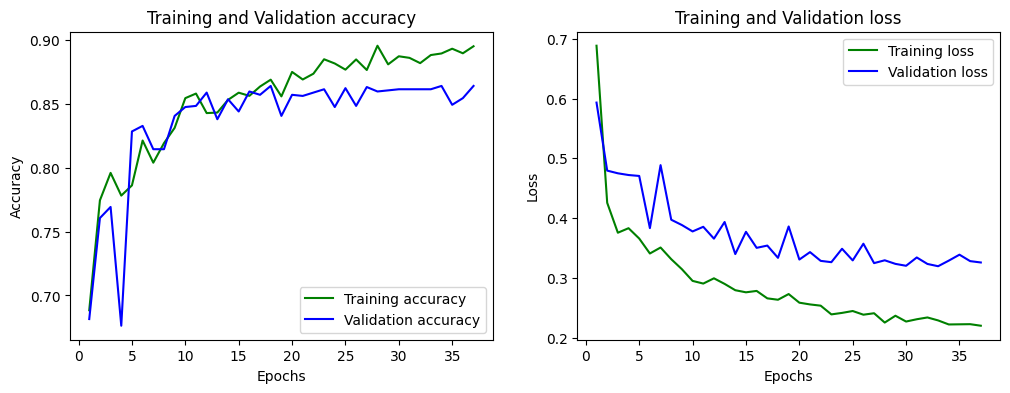

In [ ]:
accuracy_loss_plot(binary_history)

In [ ]:
y_test_probs = binary_model.predict(X_test)
y_test_pred = (y_test_probs >= 0.5).astype(int)

f1_score(y_binary_test, y_test_pred, average='weighted')

37/37 [==============================] - 22s 587ms/step


0.847086625162674

              precision    recall  f1-score   support

           0       0.81      0.70      0.75       379
           1       0.87      0.92      0.89       794

    accuracy                           0.85      1173
   macro avg       0.84      0.81      0.82      1173
weighted avg       0.85      0.85      0.85      1173



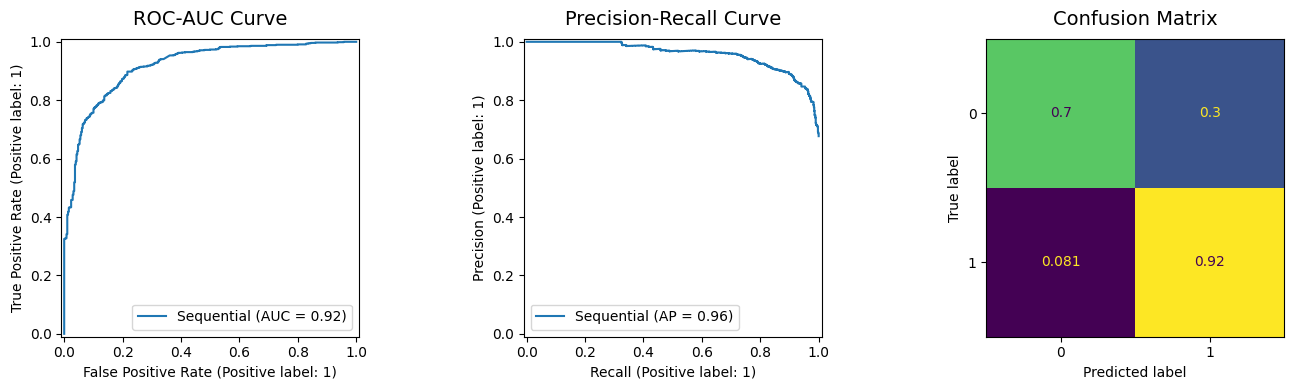

In [ ]:
evaluate_model(binary_model, y_binary_test, y_test_probs)

              precision    recall  f1-score   support

           0       0.80      0.74      0.77       372
           1       0.88      0.91      0.89       778

    accuracy                           0.85      1150
   macro avg       0.84      0.82      0.83      1150
weighted avg       0.85      0.85      0.85      1150



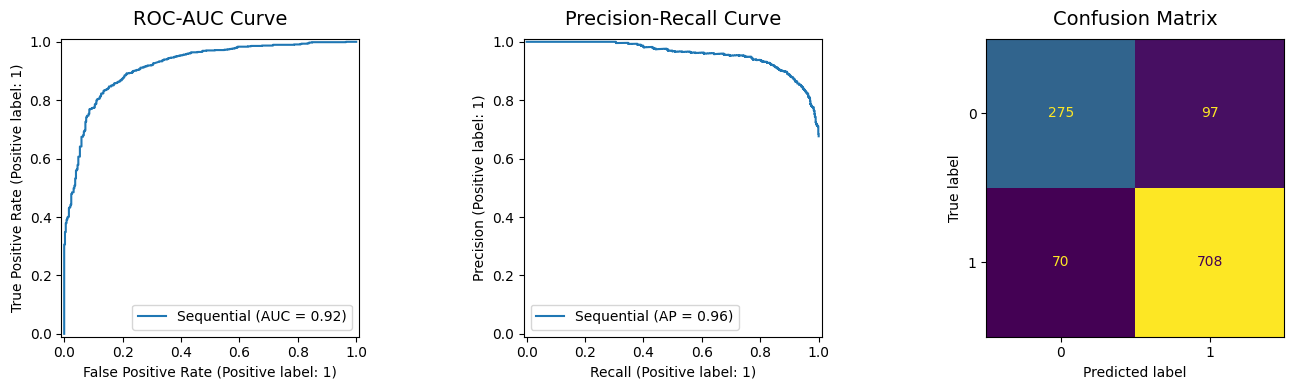

In [ ]:
evaluate_model(binary_model, y_binary_test, y_test_probs)

Evaluation by magnification type:

In [ ]:
X_test_hashes = [hash_image(x) for x in X_test]

# Find the matching indices
matching_indices = df.index[df['hash'].isin(X_test_hashes)].tolist()

# Retrieve the rows we want
X_test_info = df.loc[matching_indices]

In [ ]:
X_test_info.Magnification.value_counts()

Magnification
200X    307
100X    285
40X     283
400X    275
Name: count, dtype: int64

In [ ]:
X_test_40X = np.stack( X_test_info.loc[X_test_info.Magnification == '40X'].image )
X_test_100X = np.stack( X_test_info.loc[X_test_info.Magnification == '100X'].image )
X_test_200X = np.stack( X_test_info.loc[X_test_info.Magnification == '200X'].image )
X_test_400X = np.stack( X_test_info.loc[X_test_info.Magnification == '400X'].image )

y_test_40X = X_test_info.loc[X_test_info.Magnification == '40X'].malignant
y_test_100X = X_test_info.loc[X_test_info.Magnification == '100X'].malignant
y_test_200X = X_test_info.loc[X_test_info.Magnification == '200X'].malignant
y_test_400X = X_test_info.loc[X_test_info.Magnification == '400X'].malignant

In [ ]:
def model_predict(model, test_sets, problem):
  if problem == 'binary':
      return [ ( model.predict(test) >= 0.5 ).astype(int) for test in test_sets ]
  else:
      return [ [np.argmax(pred) for pred in model.predict(test)] for test in test_sets ]

In [ ]:
pred_40X, pred_100X, pred_200X, pred_400X = model_predict(model=binary_model, test_sets=[X_test_40X, X_test_100X, X_test_200X, X_test_400X], problem='binary')

9/9 [==============================] - 5s 530ms/step


In [ ]:
def evaluator(true, pred):
  return accuracy_score(true, pred), precision_score(true,pred), recall_score(true,pred), f1_score(true,pred,average='weighted')

In [ ]:
scores = [ evaluator(labels, mag_pred) for mag_pred, labels in
          zip([pred_40X, pred_100X, pred_200X, pred_400X], [y_test_40X, y_test_100X, y_test_200X, y_test_400X]) ]

In [ ]:
pd.DataFrame(scores, index=['40X', '100X', '200X', '400X'], columns=['Accuracy', 'Precision', 'Recall', 'Weighted F1'])

Accuracy  Precision    Recall  Weighted F1
40X   0.844523   0.861244  0.923077     0.840499
100X  0.863158   0.896373  0.901042     0.862966
200X  0.892508   0.920561  0.924883     0.892347
400X  0.814545   0.835979  0.887640     0.811751

Visualizing predictions:

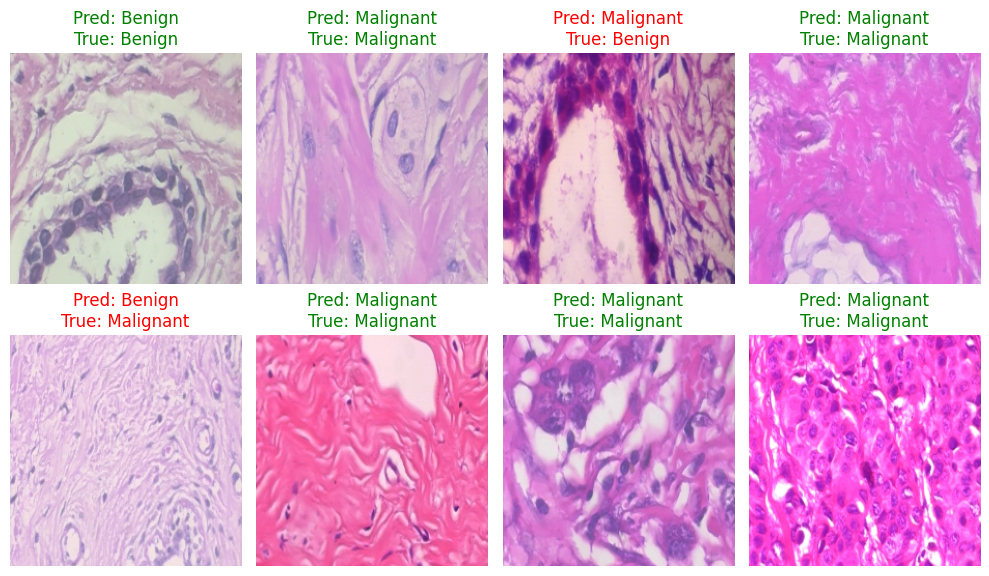

In [ ]:
indices = np.random.choice(len(X_test), 8, replace=False)

class_names = {0: "Benign",
               1: "Malignant"}

fig, axes = plt.subplots(2, 4, figsize=(10, 6))
axes = axes.ravel()

for i, idx in enumerate(indices):
    image = X_test[idx]

    # We need to rescale the image values ​​to [0, 255]
    image = (image * 255).astype("uint8")

    true_label = list(y_binary_test)[idx]
    pred_label = y_test_pred[idx]

    color = "green" if true_label == pred_label else "red"

    axes[i].imshow(image)
    axes[i].axis("off")

    title = f"Pred: {class_names[pred_label[0]]}\nTrue: {class_names[true_label]}"
    axes[i].set_title(title, color=color)

plt.tight_layout()
plt.show()

## Stage 2: Multi Class Classification

### Data Preparation

In [ ]:
X_train_multi, y_train_multi = apply_oversampling(X_train, y_multi_train, problem='multiclass', target_size=0)
X_train_multi, y_train_multi = apply_undersampling(X_train_multi, y_train_multi, percent_to_drop=0)

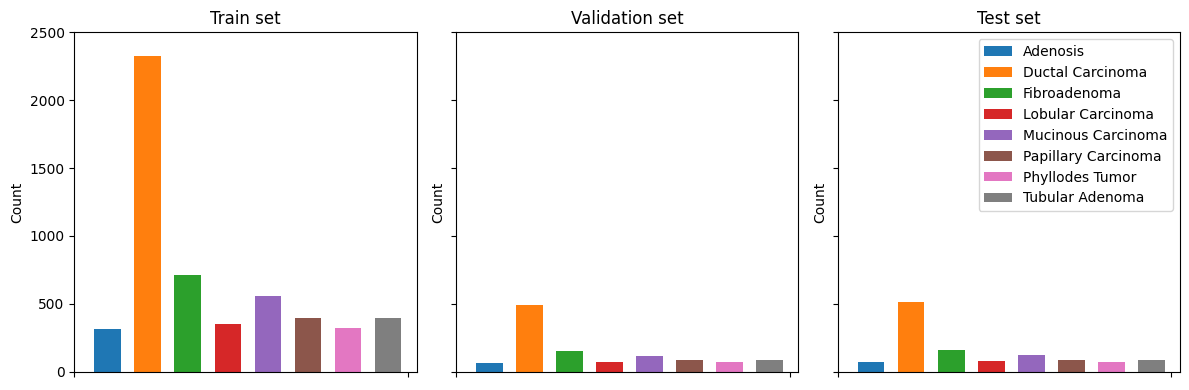

In [ ]:
train_counts = dict(sorted( Counter(y_train_multi).items() ))
val_counts = dict(sorted( Counter(y_multi_val).items() ))
test_counts = dict(sorted( Counter(y_multi_test).items() ))

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

width = 0.08

for (i, counts), split in zip( enumerate([train_counts, val_counts, test_counts]), ['Train', 'Validation', 'Test']):
    classes = list(counts.keys())
    counts = list(counts.values())

    ax[i].bar(0.1, counts[0], width=width, label='Adenosis')
    ax[i].bar(0.22, counts[1], width=width, label='Ductal Carcinoma')
    ax[i].bar(0.34, counts[2], width=width, label='Fibroadenoma')
    ax[i].bar(0.46, counts[3], width=width, label='Lobular Carcinoma')

    ax[i].bar(0.58, counts[4], width=width, label='Mucinous Carcinoma')
    ax[i].bar(0.7, counts[5], width=width, label='Papillary Carcinoma')
    ax[i].bar(0.82, counts[6], width=width, label='Phyllodes Tumor')
    ax[i].bar(0.94, counts[7], width=width, label='Tubular Adenoma')


    ax[i].set_xticks([0, 1])
    ax[i].set_xticklabels(['', ''])
    ax[i].set_title(f'{split} set')
    ax[i].set_ylabel('Count')
    ax[i].set_ylim(0, 2500)

plt.legend()
plt.tight_layout()
plt.show()

### Model Design

In [ ]:
base_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3)
                                         )
base_model.trainable = False

for layer in base_model.layers[-18:]:
   layer.trainable = True

In [ ]:
multi_model = Sequential()
multi_model.add(base_model)
multi_model.add(Flatten())
multi_model.add(Dropout(0.5))

multi_model.add(Dense(1024)) #, kernel_regularizer=L2(0.01)))
multi_model.add(BatchNormalization())
multi_model.add(Activation("relu"))
multi_model.add(Dropout(0.5))

multi_model.add(Dense(512)) #, kernel_regularizer=L2(0.01)))
multi_model.add(BatchNormalization())
multi_model.add(Activation("relu"))
multi_model.add(Dropout(0.5))

multi_model.add(Dense(256)) #, kernel_regularizer=L2(0.01)))
multi_model.add(BatchNormalization())
multi_model.add(Activation("relu"))
multi_model.add(Dropout(0.5))

multi_model.add(Dense(8, activation="softmax"))

In [ ]:
weighted_f1 = F1Score(num_classes=8, average='weighted')

# One-hot encoding the targets in order to be able to use the metric
y_train_one_hot = tf.keras.utils.to_categorical(y_train_multi, 8)
y_val_one_hot = tf.keras.utils.to_categorical(y_multi_val, 8)

In [ ]:
stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
checkpoint = ModelCheckpoint(filepath='multi_model.keras', monitor='val_f1_score', mode='max',save_best_only=True)
lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=500, decay_rate=0.9)

multi_model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=[weighted_f1])

multi_history = multi_model.fit(
    X_train_multi, y_train_one_hot,
    validation_data=[X_val, y_val_one_hot],
    epochs=50,
    steps_per_epoch=100,
    callbacks=[stopping, reduce_lr, checkpoint])#, class_weight=class_weights)

Epoch 1/50
100/100 [==============================] - 135s 1s/step - loss: 1.9780 - f1_score: 0.3279 - val_loss: 1.6680 - val_f1_score: 0.4499 - lr: 9.7935e-04
Epoch 2/50
100/100 [==============================] - 130s 1s/step - loss: 1.5534 - f1_score: 0.4367 - val_loss: 1.3111 - val_f1_score: 0.5260 - lr: 9.5893e-04
Epoch 3/50
100/100 [==============================] - 127s 1s/step - loss: 1.3608 - f1_score: 0.4937 - val_loss: 1.1707 - val_f1_score: 0.5749 - lr: 9.3894e-04
Epoch 4/50
100/100 [==============================] - 127s 1s/step - loss: 1.1890 - f1_score: 0.5533 - val_loss: 1.1032 - val_f1_score: 0.5996 - lr: 9.1936e-04
Epoch 5/50
100/100 [==============================] - 127s 1s/step - loss: 1.0797 - f1_score: 0.5944 - val_loss: 1.0629 - val_f1_score: 0.6124 - lr: 9.0019e-04
Epoch 6/50
100/100 [==============================] - 127s 1s/step - loss: 0.9952 - f1_score: 0.6231 - val_loss: 1.0752 - val_f1_score: 0.6220 - lr: 8.8142e-04
Epoch 7/50
100/100 [====================

### Model Evaluation

In [ ]:
# Load model
model_name = "multimodel"

multi_model = keras.saving.load_model(model_name + ".keras", custom_objects=None, compile=True, safe_mode=True)

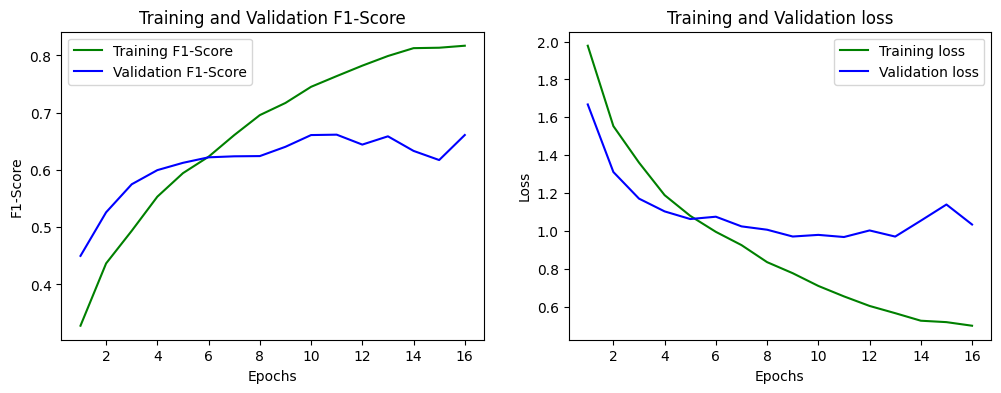

In [ ]:
f1_loss_plot(multi_history)

In [ ]:
y_test_probs = multi_model.predict((X_test))
y_test_pred = np.array([np.argmax(pred) for pred in y_test_probs])
f1_score(y_multi_test, y_test_pred, average='weighted')

37/37 [==============================] - 23s 625ms/step


0.6655097799481692

In [ ]:
print(classification_report(y_multi_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.58      0.72      0.64        68
           1       0.78      0.87      0.82       510
           2       0.66      0.54      0.59       155
           3       0.52      0.32      0.40        77
           4       0.54      0.49      0.51       121
           5       0.51      0.50      0.51        86
           6       0.46      0.57      0.51        69
           7       0.72      0.56      0.63        87

    accuracy                           0.67      1173
   macro avg       0.60      0.57      0.58      1173
weighted avg       0.67      0.67      0.67      1173



In [ ]:
np.arange(8)

array([0, 1, 2, 3, 4, 5, 6, 7])

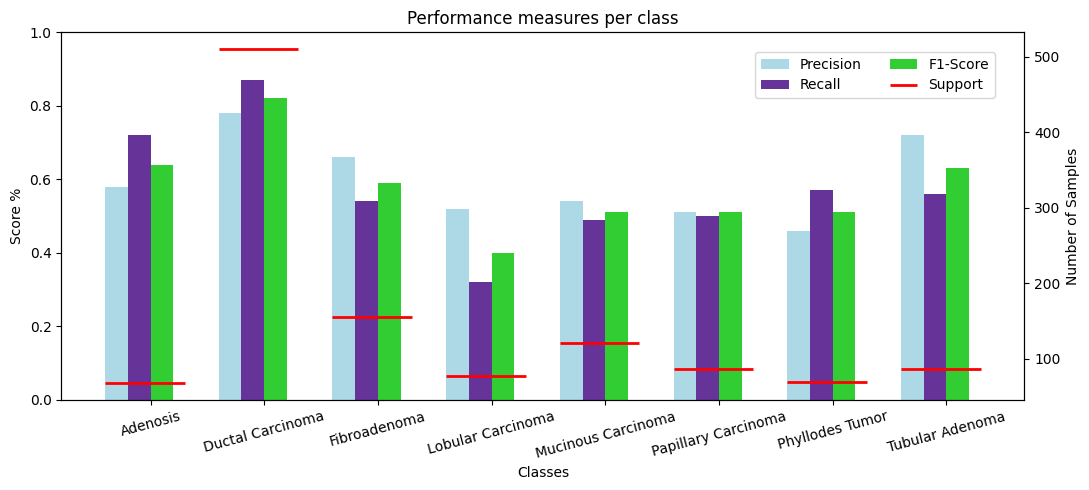

In [ ]:
precision = [0.58, 0.78, 0.66, 0.52, 0.54, 0.51, 0.46, 0.72]
recall = [0.72, 0.87, 0.54, 0.32, 0.49, 0.50, 0.57, 0.56]
f1_score = [0.64, 0.82, 0.59, 0.40, 0.51, 0.51, 0.51, 0.63]
support = [68, 510, 155, 77, 121, 86, 69, 87]
classes = ['Adenosis', 'Ductal Carcinoma', 'Fibroadenoma', 'Lobular Carcinoma',
           'Mucinous Carcinoma', 'Papillary Carcinoma', 'Phyllodes Tumor', 'Tubular Adenoma']

x = np.arange(8)
bar_width = 0.2

fig, ax1 = plt.subplots(figsize=(11, 5))
ax1.bar(x - 1.5 * bar_width, precision, bar_width, label='Precision', color='lightblue')
ax1.bar(x - 0.5 * bar_width, recall, bar_width, label='Recall', color='rebeccapurple')
ax1.bar(x + 0.5 * bar_width, f1_score, bar_width, label='F1-Score', color='limegreen')

ax1.set_xlabel('Classes')
ax1.set_ylabel('Score %')
ax1.set_ylim(0, 1)
ax1.set_title('Performance measures per class')
ax1.set_xticks(x)
ax1.set_xticklabels(classes, rotation=15)

ax2 = ax1.twinx()
ax2.hlines(support, xmin=x - 2 * bar_width, xmax=x + 1.5 * bar_width, color='red', label='Support', linewidth=2)
ax2.set_ylabel('Number of Samples')

fig.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.8, .9))

plt.tight_layout()
plt.show()

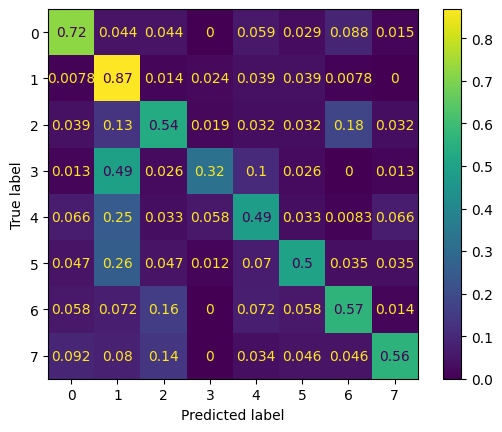

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_multi_test, y_test_pred, normalize='true')

By magnification:

In [ ]:
X_test_hashes = [hash_image(x) for x in X_test]

# Find the matching indices
matching_indices = df.index[df['hash'].isin(X_test_hashes)].tolist()

# Retrieve the rows we want
X_test_info = df.loc[matching_indices]

In [ ]:
X_test_40X = ( np.stack( X_test_info.loc[X_test_info.Magnification == '40X'].image ) )
X_test_100X = ( np.stack( X_test_info.loc[X_test_info.Magnification == '100X'].image ) )
X_test_200X = ( np.stack( X_test_info.loc[X_test_info.Magnification == '200X'].image ) )
X_test_400X = ( np.stack( X_test_info.loc[X_test_info.Magnification == '400X'].image ) )

y_test_40X = enc.fit_transform(X_test_info.loc[X_test_info.Magnification == '40X'].cancer_type)
y_test_100X = enc.fit_transform(X_test_info.loc[X_test_info.Magnification == '100X'].cancer_type)
y_test_200X = enc.fit_transform(X_test_info.loc[X_test_info.Magnification == '200X'].cancer_type)
y_test_400X = enc.fit_transform(X_test_info.loc[X_test_info.Magnification == '400X'].cancer_type)

In [ ]:
pred_40X, pred_100X, pred_200X, pred_400X = model_predict(model=multi_model,
                                                          test_sets=[X_test_40X, X_test_100X, X_test_200X, X_test_400X],
                                                          problem='multiclass')

9/9 [==============================] - 5s 581ms/step


In [ ]:
def evaluator(true, pred):
  return accuracy_score(true, pred), precision_score(true,pred, average='weighted'), recall_score(true,pred, average='weighted'), f1_score(true,pred,average='weighted')

In [ ]:
scores = [ evaluator(labels, mag_pred) for mag_pred, labels in
          zip([pred_40X, pred_100X, pred_200X, pred_400X], [y_test_40X, y_test_100X, y_test_200X, y_test_400X]) ]

pd.DataFrame(scores, index=['40X', '100X', '200X', '400X'], columns=['Accuracy', 'Precision', 'Recall', 'Weighted F1'])

Accuracy  Precision    Recall  Weighted F1
40X   0.701031   0.702994  0.701031     0.695162
100X  0.704467   0.703985  0.704467     0.703002
200X  0.696486   0.694576  0.696486     0.687227
400X  0.586331   0.573313  0.586331     0.563442

Visualizing predictions:

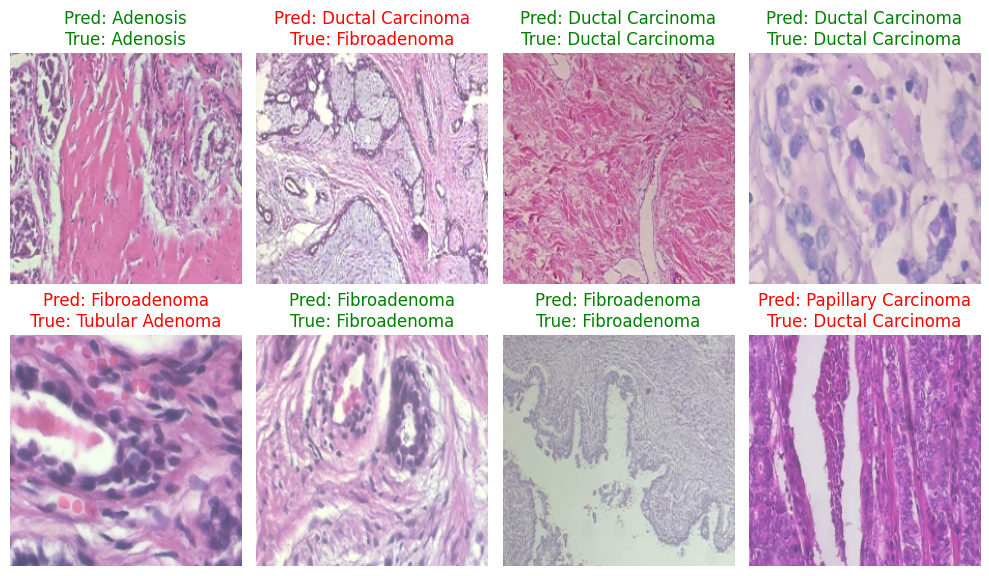

In [ ]:
indices = np.random.choice(len(X_test), 8, replace=False)

class_names = {
    0: "Adenosis",
    1: "Ductal Carcinoma",
    2: "Fibroadenoma",
    3: "Lobular Carcinoma",
    4: "Mucinous Carcinoma",
    5: "Papillary Carcinoma",
    6: "Phyllodes Tumor",
    7: "Tubular Adenoma"
}

fig, axes = plt.subplots(2, 4, figsize=(10,  6))
axes = axes.ravel()

for i, idx in enumerate(indices):
    image = X_test[idx]

    image = (image * 255).astype("uint8")

    true_label = y_multi_test[idx]
    pred_label = y_test_pred[idx]

    color = "green" if true_label == pred_label else "red"

    axes[i].imshow(image)
    axes[i].axis("off")

    title = f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}"
    axes[i].set_title(title, color=color)

plt.tight_layout()
plt.show()